# I. Khai báo thư viện cần thiết

In [1]:
import numpy as np 
import seaborn as sn 
import matplotlib.pyplot as plt 
import pandas as pd 
import cv2 # Xử lý ảnh

import os # Xử lý hệ thống file, thư mục
import tarfile # Giải nén file dữ liệu tải về
import pickle

# II. Tải và giải nén dữ liệu

Tập dữ liệu được sử dụng xuyên suốt bài lab là CIFAR-10. Có thể tải tại link: https://www.cs.toronto.edu/~kriz/cifar.html

Sau khi tải xong, dữ liệu là file nén ``.tar.gz``, ta sẽ thực hiện giải nén nó bằng code

In [2]:
tarfile_path = "../data/images/cifar-10-python.tar.gz"
extracted_path = "../data/images"

with tarfile.open(tarfile_path, "r:gz") as tar:
    tar.extractall(path=extracted_path)

os.rename(
    os.path.join(extracted_path, "cifar-10-batches-py"),
    os.path.join(extracted_path, "cifar-10")
)

print("Finish extracting CIFAR-10 dataset!")

C:\Users\DELL\AppData\Local\Temp\ipykernel_21776\3280007309.py:5: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=extracted_path)


Finish extracting CIFAR-10 dataset!


Như vậy, sau khi giải nén dữ liệu ra thì thư mục sẽ có dạng như sau: 
- Thư mục dữ liệu ``cifar-10``:
    - ``batches.meta``: Chứa metadata của dataset, đặc biệt là danh sách tên các lớp
    - Các file ``data_batch_i`` (i từ 1 đến 5): Mỗi file chứa 10,000 ảnh huấn luyện dưới dạng vector pixel (tổng cộng 50,000 ảnh train)
    - File link thông tin ``readme.html``
    - File dữ liệu test ``test_batch``: Chứa 10,000 ảnh dùng cho tập kiểm tra (test set).

Một số thông tin sơ lược về dữ liệu:
- **Kích thước tập dữ liệu**: Tập dữ liệu chứa 60,000 tấm ảnh màu
- **Kích thước ảnh**: Mỗi tấm ảnh màu kích thước 32 x 32
- **Số lớp**: Dữ liệu có tổng cộng 10 lớp (Giống như tên CIFAR-10)
- **Phân chia**: Như đã đề cập, dữ liệu huấn luyện bao gồm 50,000 tấm ảnh và dữ liệu test bao gồm 10,000 tấm ảnh

# III. Tìm hiểu dữ liệu

## 1. Kích thước tập dữ liệu và ảnh

Như vậy, ta đã kiểm tra được rằng dữ liệu huấn luyện (50,000 tấm ảnh kích thước 32 x 32) và dữ liệu kiểm tra (10,000 tấm ảnh kích thươc 32 x 32). Toàn bộ ảnh là RGB có số channel là 3.

In [3]:
DATA_DIR = "../data/images/cifar-10"

def load_batch(file_path):
    '''
    Hàm dùng để load batch trong dataset 
    Input: file_path (địa chỉ đường dẫn)
    Output: X(N,32,32,3), y (Ảnh và label)
    '''
    with open(file_path, "rb") as f:
        batch = pickle.load(f, encoding="bytes")
    X = batch[b"data"] # Kích thước (N, 3072)
    y = batch[b"labels"]
    X = X.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1) # Chuyển sang (N, 32, 32, 3)
    return X, np.array(y)

# Load tập training 
X_train, y_train = [], []
for i in range(1, 6):
    X, y = load_batch(os.path.join(DATA_DIR, f"data_batch_{i}"))
    X_train.append(X)
    y_train.append(y)

X_train = np.concatenate(X_train)
y_train = np.concatenate(y_train)

# Load tập test
X_test, y_test = load_batch(os.path.join(DATA_DIR, "test_batch"))

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (50000, 32, 32, 3)
Test shape: (10000, 32, 32, 3)


## 2. Số lượng và phân bố class

Như vậy, có tổng cộng 10 class bao gồm: ``airplane`` (máy bay), ``automobile`` (ô tô), ``bird`` (chim), ``cat`` (mèo), ``deer`` (hươu), ``dog`` (chó), ``frog`` (ếch), ``horse`` (ngựa), ``ship`` (thuyền), ``truck`` (xe tải).

In [4]:
with open(os.path.join(DATA_DIR, "batches.meta"), "rb") as f:
    meta = pickle.load(f, encoding="bytes")
label_names = [x.decode("utf-8") for x in meta[b"label_names"]]

print("Classes:", label_names)

Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


Kiểm tra phân bố, tất cả các nhãn trong huấn luyện đều có số lượng là 5000 tức dữ liệu huấn luyện đều, không bị lệch, phù hợp để huấn luyện

In [5]:
for i in range(len(label_names)):
    cnt = (y_train == i).sum()
    print(f"{label_names[i]}: {cnt}")

airplane: 5000
automobile: 5000
bird: 5000
cat: 5000
deer: 5000
dog: 5000
frog: 5000
horse: 5000
ship: 5000
truck: 5000


## 3. Hiển thị một vài ảnh mẫu tương ứng với các label

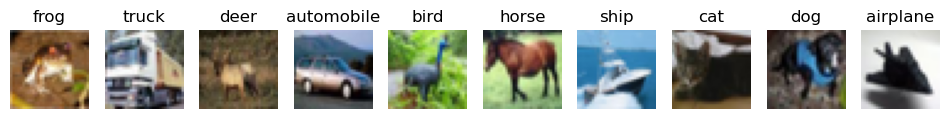

In [6]:
# Hiển thị ảnh theo label khác nhau
def show_samples(X, y, labels, n=10):
    shown = set() # Lưu vào set
    plt.figure(figsize=(12, 3))
    idx = 1
    
    for i in range(len(y)):
        cls = y[i]
        if cls not in shown:
            plt.subplot(1, 10, idx)
            plt.imshow(X[i])
            plt.title(labels[cls])
            plt.axis("off")
            shown.add(cls)
            idx += 1
        if len(shown) == 10:
            break
    plt.show()

show_samples(X_train, y_train, label_names, n=10)

# IV. Kĩ thuật tiền xử lý

## 1. Load và thay đổi kích thước ảnh

Ta sẽ thử thực hiện thay đổi kích thước ảnh trên 5 tấm ảnh đầu tiên trong tập dữ liệu huấn luyện bằng thư viện Open-CV. Kích thước ảnh ban đầu trong tập dữ liệu là 32 x 32, ta sẽ thay đổi về kích thước khác nhau như: 16 x 16, 64 x 64, 128 x 128 và 256 x 256 và sẽ thảo luận về cách sử dụng trong báo cáo. 

In [7]:
k = 5 # Số lượng tấm ảnh
def resize_images(X, size=(128, 128)):
    resized = []
    for img in X:
        img_resized = cv2.resize(img, size) # Thay đổi kích thước ảnh lại
        resized.append(img_resized)
    return np.array(resized)

X_train_16 = resize_images(X_train[:k], (16, 16))
X_train_32 = X_train[:k]
X_train_64 = resize_images(X_train[:k], (64, 64))
X_train_128 = resize_images(X_train[:k], (128, 128))
X_train_256 = resize_images(X_train[:k], (256, 256))    

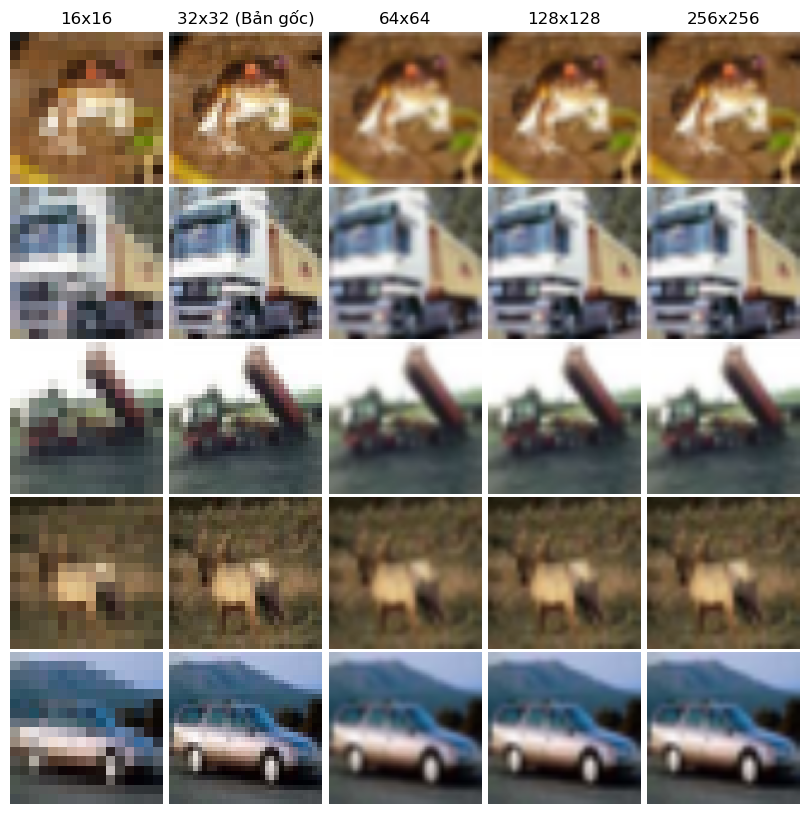

In [8]:
sizes = [X_train_16, X_train_32, X_train_64, X_train_128, X_train_256]
titles = ["16x16", "32x32 (Bản gốc)", "64x64", "128x128", "256x256"]

fig, axes = plt.subplots(k, 5, figsize=(8, 8))

for row in range(k):
    for col in range(5):
        img = sizes[col][row]
        axes[row, col].imshow(img)
        axes[row, col].axis("off")
        if row == 0:
            axes[row, col].set_title(titles[col])

plt.tight_layout(pad=0.2)
plt.show()

Ta có thể rút ra các nhận xét sau:
- Hình càng lớn thì càng "sắc nét" hơn, tức là thông tin ảnh mang càng chi tiết hơn và ngược lại (chẳng hạn như hình con ếch, hình kích thước quá nhỏ như 16x16 rất khó để nhận dạng)
- Tuy nhiên, đánh đổi với thông tin chi tiết nó mang lại, đó chính là bộ nhớ. Ảnh càng lớn chắc chắn sẽ cần lưu trữ nhiều hơn ảnh nhỏ

## 2. Chuyển ảnh Grayscale

Ảnh ban đầu của ta là một ảnh RGB (mỗi pixel chứa thông tin giá trị của ba màu Red, Green, Blue) tức là số channel của ảnh là 3. Để có thể chuyển sang ảnh Grayscale (ảnh màu đen trắng) tức pixel chỉ chứa một giá trị duy nhất từ 0 đến 255 (từ đen đến trắng), ta sẽ tìm ánh xạ từ không gian 3 chiều về không gia 1 chiều. Một trong ánh xạ đơn giản, đó chính là tích vô hướng. 

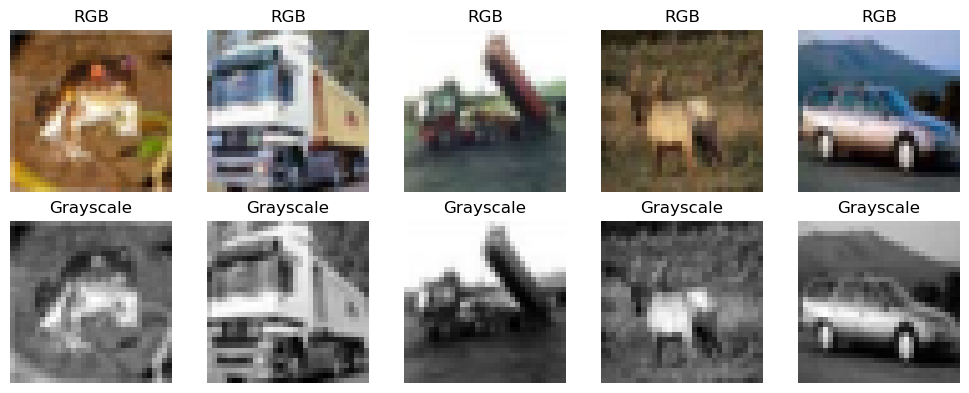

In [9]:
def convert_rgb_to_grayscale(X, color_weight):
    '''
    Chuyển ảnh RGB sang grayscale
    Đầu vào: X (N, 32, 32, 3) 
             color_index (3,)
    Output: (N, 32, 32)
    '''
    return np.dot(X[..., :3], color_weight).astype(np.uint8) # Ép về int trong khoảng [0,255] cho giống gốc dễ so sánh memory

# Đặt vector chỉ trọng số màu theo Rec. 601
weight = np.array([0.299, 0.587, 0.114])

X_grayscale = convert_rgb_to_grayscale(X_train[:k], weight) # Chuyển 5 tấm ảnh (k = 5) khai báo trên

fig, axes = plt.subplots(2, 5, figsize=(10, 4))

for i in range(k):
    axes[0, i].imshow(X_train[i])
    axes[0, i].set_title("RGB")
    axes[0, i].axis("off")

    axes[1, i].imshow(X_grayscale[i], cmap="gray")
    axes[1, i].set_title("Grayscale")
    axes[1, i].axis("off")

plt.tight_layout()
plt.show()

Như vậy, ta có thể thấy được là về mặt tổng quan thị giác, cấu trúc hình ảnh như biên cạnh, độ đậm nhạt của ảnh gốc vẫn không thay đổi. Chỉ khác là ảnh Grayscale không mang thông tin màu sắc tốt như ảnh RGB gốc nữa. Về bản chất, thông tin dữ liệu mà pixel Grayscale chứa rõ ràng ít hơn thông tin pixel RGB nắm giữ (cụ thể nhỏ hơn 3 lần). Ta có thể kiểm chứng bằng code:

In [10]:
print("RGB size (bytes):", X_train[:k].nbytes)
print("Grayscale size (bytes):", X_grayscale.nbytes)
print("Reduction ratio:", X_train[:k].nbytes / X_grayscale.nbytes)

RGB size (bytes): 15360
Grayscale size (bytes): 5120
Reduction ratio: 3.0


Ta có thể khảo sát sự thay đổi về phân phối giá trị trong channel khi chuyển ảnh từ RGB sang Grayscale. Có thể thấy, phân phối của kênh màu xanh lá (Green) gần giống với phân phối của ảnh Grayscale và trái lại, phân phối kênh màu biển (Blue) lại khác hoàn toàn. Điều này phụ thuộc vào các giá trị trọng số mà ta truyền vào:

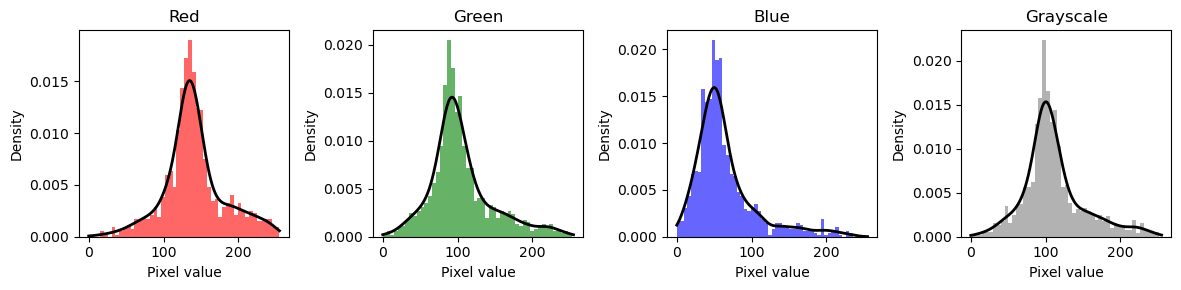

In [11]:
from scipy.stats import gaussian_kde

img_rgb = X_train[0]
img_gray = convert_rgb_to_grayscale(img_rgb, weight)

plt.figure(figsize=(12,3))

def plot_hist_kde(data, color, title):
    data = data.ravel()
    kde = gaussian_kde(data)
    x = np.linspace(0, 255, 256)
    
    plt.hist(data, bins=50, density=True, alpha=0.6, color=color)
    plt.plot(x, kde(x), color="black", linewidth=2)
    plt.title(title)
    plt.xlabel("Pixel value")
    plt.ylabel("Density")

plt.subplot(1,4,1)
plot_hist_kde(img_rgb[:,:,0], "red", "Red")

plt.subplot(1,4,2)
plot_hist_kde(img_rgb[:,:,1], "green", "Green")

plt.subplot(1,4,3)
plot_hist_kde(img_rgb[:,:,2], "blue", "Blue")

plt.subplot(1,4,4)
plot_hist_kde(img_gray, "gray", "Grayscale")

plt.tight_layout()
plt.show()

## 3. Chuẩn hóa 

### a. Chuẩn hóa pixel

Một trong những cách làm đó chính là Max-Min scaling khi ta có thể chuyển một giá trị một channel về một khoảng [a,b] cho trước bằng công thức: x' = a + (x - x_min)/(x_max - x_min)(b-a)

In [12]:
def min_max_normalization(X, a = 0.0, b = 1.0):
    X = X.astype(np.float32)
    
    x_min = X.min(axis=(1,2,3), keepdims=True)
    x_max = X.max(axis=(1,2,3), keepdims=True)

    X_norm = a + (X - x_min) * (b - a) / (x_max - x_min + 1e-8)
    return X_norm

X_01 = min_max_normalization(X_train, 0, 1) # Về khoảng [0,1]
X_11 = min_max_normalization(X_train, -1, 1) # Về khoảng [-1,1]

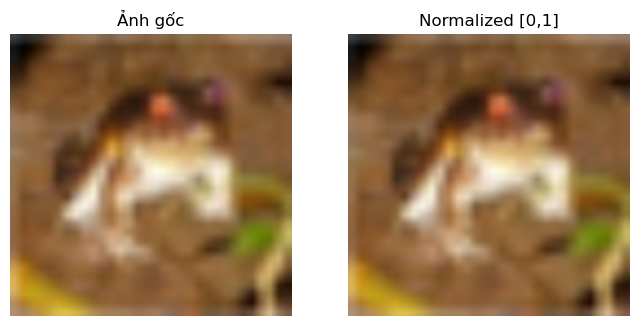

In [130]:
plt.figure(figsize=(8,4))

original_image = resize_images(X_train[:1])[0]
normalized_image = resize_images(X_01[:1])[0]

plt.subplot(1,2,1)
plt.imshow(original_image.astype(np.uint8))
plt.title("Ảnh gốc")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(normalized_image)
plt.title("Normalized [0,1]")
plt.axis("off")

plt.show()

Ta có thể tấy histogram chúng như nhau và phân phối cũng vậy. Điều này minh chứng Normalization là một phép biến đổi tuyến tính, chỉ thay đổi đơn vị biểu diễn chứ không làm biến dạng đặc trưng gốc của ảnh.

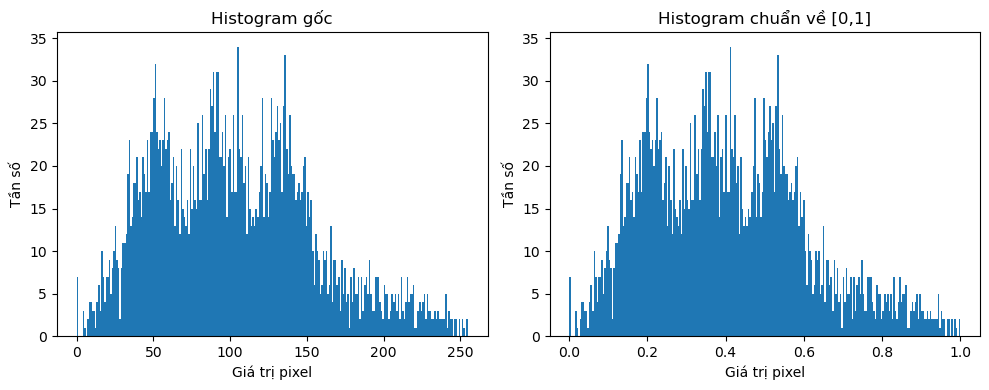

In [55]:
original = X_train[0]
norm = X_01[0]

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.hist(original.flatten(), bins=256)
plt.title("Histogram gốc")
plt.xlabel("Giá trị pixel")
plt.ylabel("Tần số")

plt.subplot(1,2,2)
plt.hist(norm.flatten(), bins=256)
plt.title("Histogram chuẩn về [0,1]")
plt.xlabel("Giá trị pixel")
plt.ylabel("Tần số")

plt.tight_layout()
plt.show()

### b. Chuẩn hóa Z-score

Đây là kỹ thuật tiền xử lý dữ liệu nhằm biến đổi các giá trị đầu vào sao cho có trung bình bằng 0 và độ lệch chuẩn bằng 1 theo công thức:
x' = (x - mu)/sigma 

In [15]:
def standardization(X):
    X = X.astype(np.float32)
    
    mean = X.mean(axis=(1,2), keepdims=True)   
    std = X.std(axis=(1,2), keepdims=True) 
    
    X_std = (X - mean) / std
    return X_std

X_std = standardization(X_train)

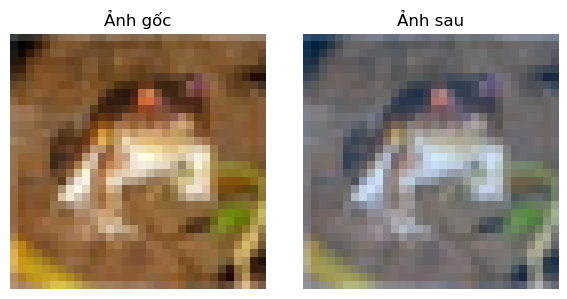

In [56]:
img_original = X_train[0]
img_std = X_std[0]

fig, axes = plt.subplots(1, 2, figsize=(6,3))

axes[0].imshow(img_original.astype(np.uint8))
axes[0].set_title("Ảnh gốc")
axes[0].axis("off")

# Rescale standardized để hiển thị
axes[1].imshow((img_std - img_std.min()) / (img_std.max() - img_std.min()))
axes[1].set_title("Ảnh sau")
axes[1].axis("off")

plt.tight_layout()
plt.show()

Ta thấy histogram của hai ảnh hoàn toàn thay đổi ngỡ ngàng!

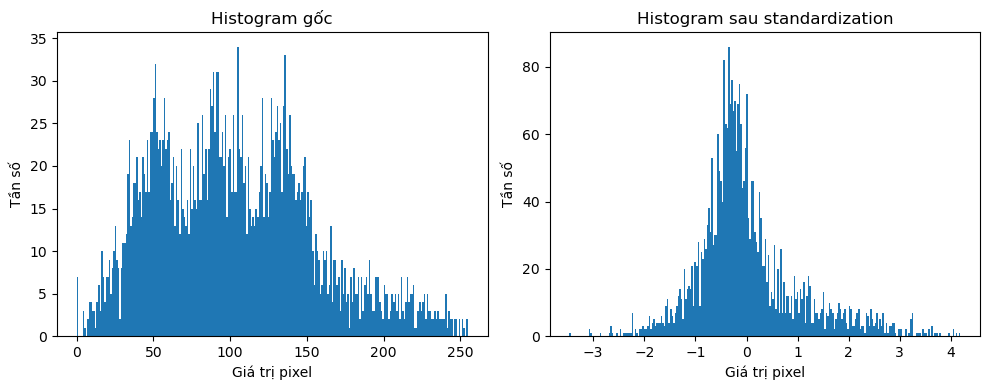

In [57]:
original = X_train[0]
std_img = X_std[0]

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.hist(original.flatten(), bins=256)
plt.title("Histogram gốc")
plt.xlabel("Giá trị pixel")
plt.ylabel("Tần số")

plt.subplot(1,2,2)
plt.hist(std_img.flatten(), bins=256)
plt.title("Histogram sau standardization")
plt.xlabel("Giá trị pixel")
plt.ylabel("Tần số")

plt.tight_layout()
plt.show()

## 4. Xác định biên cạnh

Trong phần này, ta sẽ thực hiện xác định biên cạnh với các kernel khác nhau, cụ thể ta sẽ điểm qua thuật toán Sobel, Prewitt, Canny và minh họa cách nó lấy ra biên cạnh hiển thị trên tấm ảnh. Ta sẽ reimplement lại hai thuật toán đơn giản kia và dùng thư viện OpenCV cho thuật toán Canny cho thuận tiện.

Một trong những phép cơ bản trong các thuật toán xác định biên cạnh đó chính là phép convolution. Ta sẽ implement hàm này với đầu vào là ảnh và một kernel để "trượt":

In [58]:
def convolution(img, kernel):
    img = img.astype(np.float32)
    kernel = kernel.astype(np.float32)

    h, w = img.shape
    kh, kw = kernel.shape
    ph, pw = kh // 2, kw // 2

    padded = np.pad(img, ((ph, ph), (pw, pw)), mode='edge')
    output = np.zeros((h, w), dtype=np.float32)

    for i in range(h):
        for j in range(w):
            region = padded[i:i+kh, j:j+kw]
            output[i, j] = np.sum(region * kernel)

    return output

### a. Thuật toán Sobel

Thuật toán đầu tiên, Sobel phát hiện biên bằng cách tính gradient cường độ sáng theo hai hướng ngang và dọc bằng hai kernel. Độ lớn gradient biểu diễn mức thay đổi cường độ, tương ứng với biên ảnh.

In [36]:
def sobel(X):
    X = X.astype(np.float32)

    Gx = np.array([[-1,0,1],
                   [-2,0,2],
                   [-1,0,1]])

    Gy = np.array([[-1,-2,-1],
                   [ 0, 0, 0],
                   [ 1, 2, 1]])

    sx = convolution(X, Gx)
    sy = convolution(X, Gy)

    return np.sqrt(sx**2 + sy**2)

Đây là ảnh minh họa kết quả thuật toán Sobel, ta sẽ resize nó về 128 cho hình ảnh dễ nhìn hơn:

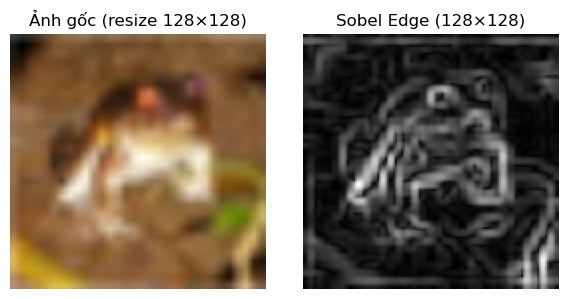

In [59]:
img_original = resize_images(X_train[:1])[0]

img_gray = convert_rgb_to_grayscale(
    X_train[:1], np.array([0.299, 0.587, 0.114])
)[0].astype(np.float32)

img_gray_resize = resize_images(img_gray[None, ...], (128,128))[0]

img_edge = sobel(img_gray_resize)

fig, axes = plt.subplots(1, 2, figsize=(6,3))

axes[0].imshow(img_original.astype(np.uint8))
axes[0].set_title("Ảnh gốc (resize 128×128)")
axes[0].axis("off")

axes[1].imshow(img_edge, cmap="gray")
axes[1].set_title("Sobel Edge (128×128)")
axes[1].axis("off")

plt.tight_layout()
plt.show()

### b. Thuật toán Prewitt

Prewitt tương tự Sobel nhưng dùng kernel đơn giản hơn để ước lượng gradient theo hai hướng. Thuật toán nhanh nhưng nhạy nhiễu hơn Sobel:

In [40]:
def prewitt(img):
    img = img.astype(np.float32)

    Px = np.array([[-1,0,1],
                   [-1,0,1],
                   [-1,0,1]])
    Py = np.array([[-1,-1,-1],
                   [ 0, 0, 0],
                   [ 1, 1, 1]])

    px = convolution(img, Px)
    py = convolution(img, Py)
    return np.sqrt(px**2 + py**2)

Tương tự, ta sẽ minh họa hình ảnh góc cạnh với thuật toán Prewitt:

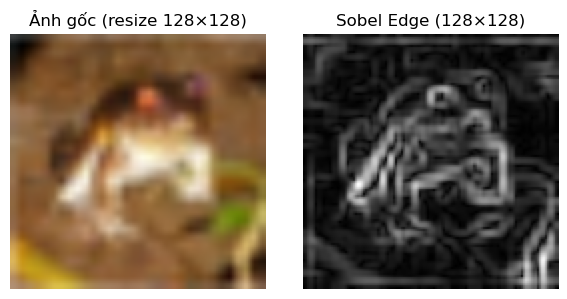

In [ ]:
img_original = resize_images(X_train[:1])[0]

img_gray = convert_rgb_to_grayscale(
    X_train[:1], np.array([0.299, 0.587, 0.114])
)[0].astype(np.float32)

img_gray_resize = resize_images(img_gray[None, ...], (128,128))[0]

img_edge = prewitt(img_gray_resize)

fig, axes = plt.subplots(1, 2, figsize=(6,3))

axes[0].imshow(img_original.astype(np.uint8))
axes[0].set_title("Ảnh gốc (resize 128×128)")
axes[0].axis("off")

axes[1].imshow(img_edge, cmap="gray")
axes[1].set_title("Sobel Edge (128×128)")
axes[1].axis("off")

plt.tight_layout()
plt.show()

### c. Thuật toán Canny

Thuật toán Canny là thuật toán hiện đại và bao gồm nhiều bước hơn so với hai thuật toán thực hiện trước đó:
- Bước 1: Làm mượt ảnh bằng Gaussian filter để giảm nhiễu
- Bước 2: Tính gradient
- Bước 3: Non-maximum suppression để làm biên mảnh
- Bước 4: Double threshold + hysteresis để giữ biên mạnh và loại nhiễu

Trong phần này, ta sẽ dùng thư viện OpenCV để thuận tiện:

In [111]:
img_original = resize_images(X_train[:1])[0]

img_gray = convert_rgb_to_grayscale(
    X_train[:1], np.array([0.299, 0.587, 0.114])
)[0].astype(np.uint8)

img_gray = resize_images(img_gray[None, ...], (128,128))[0]

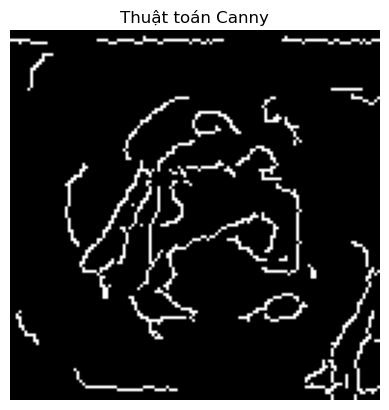

In [129]:
edges = cv2.Canny(img_gray, threshold1=50, threshold2=100)
plt.imshow(edges, cmap="gray")
plt.title("Thuật toán Canny")
plt.axis("off")
plt.show()